<a href="https://colab.research.google.com/github/maradihno/JJTechTower/blob/main/CSIT599_Module2_In_Class_Exercise_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSIT 599 - Module 2 In Class Exercise



## Cats vs Dogs Classification using Convolutional Neural Networks (CNN)

### Exercise for Students

This exercise demonstrates the power of CNNs for image classification tasks.

Downloads dataset to current working directory to avoid permission issues.


This exercise demonstrates the progression from basic CNNs to modern techniques
in a step-by-step sequential manner:

- STEP 1: Data preparation
- STEP 2: Build and train Vanilla CNN (basic, no tricks)
- STEP 3: Build and train Improved CNN (with modern techniques)  
- STEP 4: Compare performance and analyze results


You'll learn about:
- Image preprocessing and data augmentation
- Convolutional layers and feature maps
- Pooling layers and dimensionality reduction
- CNN architecture design
- Training with callbacks and regularization

Instructions:
1. Fill in the blanks marked with "# TODO: STUDENT FILL IN"
2. Run the code and observe the CNN's performance
3. Experiment with different architectures and hyperparameters

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import urllib.request
import zipfile

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# ============================================================================
# STEP 1: DATA PREPARATION
# ============================================================================

def download_cats_dogs_dataset():
    """Download cats vs dogs dataset to current working directory."""
    print("STEP 1: DOWNLOADING CATS VS DOGS DATASET")
    print("="*50)

    current_dir = os.getcwd()
    dataset_dir = os.path.join(current_dir, "cats_dogs_dataset")
    zip_path = os.path.join(current_dir, "cats_and_dogs.zip")

    dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

    print(f"Working directory: {current_dir}")
    print(f"Dataset will be saved to: {dataset_dir}")

    # Check if dataset already exists
    if os.path.exists(dataset_dir):
        print("Dataset already exists locally!")
        train_dir = os.path.join(dataset_dir, "train")
        validation_dir = os.path.join(dataset_dir, "validation")

        if verify_dataset_structure(train_dir, validation_dir):
            return train_dir, validation_dir
        else:
            print("Existing dataset is incomplete. Re-downloading...")
            import shutil
            shutil.rmtree(dataset_dir)

    try:
        # Download the zip file
        print(f"Downloading from: {dataset_url}")
        print("This may take a few minutes...")

        def progress_hook(block_num, block_size, total_size):
            downloaded = block_num * block_size
            if total_size > 0:
                percent = min(100, (downloaded * 100) / total_size)
                mb_downloaded = downloaded / (1024 * 1024)
                mb_total = total_size / (1024 * 1024)
                print(f"\rProgress: {percent:.1f}% ({mb_downloaded:.1f}/{mb_total:.1f} MB)",
                      end='', flush=True)

        urllib.request.urlretrieve(dataset_url, zip_path, reporthook=progress_hook)
        print(f"\nDownload completed: {zip_path}")

        # Extract the zip file
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(current_dir)

        # Find the extracted directory
        extracted_dir = None
        for item in os.listdir(current_dir):
            if os.path.isdir(item) and "cats_and_dogs" in item.lower():
                extracted_dir = os.path.join(current_dir, item)
                break

        if extracted_dir:
            if extracted_dir != dataset_dir:
                os.rename(extracted_dir, dataset_dir)
        else:
            raise Exception("Could not find extracted dataset directory")

        # Clean up zip file
        if os.path.exists(zip_path):
            os.remove(zip_path)
            print("Cleaned up zip file")

        train_dir = os.path.join(dataset_dir, "train")
        validation_dir = os.path.join(dataset_dir, "validation")

        if verify_dataset_structure(train_dir, validation_dir):
            print("Dataset setup completed successfully!")
            return train_dir, validation_dir
        else:
            raise Exception("Dataset structure verification failed")

    except Exception as e:
        print(f"Download failed: {str(e)}")
        print("Creating minimal demo dataset...")
        return create_minimal_demo_dataset()

def verify_dataset_structure(train_dir, validation_dir):
    """Verify that the dataset has the expected structure."""
    required_dirs = [
        os.path.join(train_dir, 'cats'),
        os.path.join(train_dir, 'dogs'),
        os.path.join(validation_dir, 'cats'),
        os.path.join(validation_dir, 'dogs')
    ]

    print("\nVerifying dataset structure...")
    for dir_path in required_dirs:
        if not os.path.exists(dir_path):
            print(f"Missing directory: {dir_path}")
            return False

        image_files = [f for f in os.listdir(dir_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"{len(image_files)} images in {os.path.basename(dir_path)}")

        if len(image_files) == 0:
            print(f"No images found in: {dir_path}")
            return False

    return True

In [5]:
# STEP 1: Data Preparation
print("CATS vs DOGS CNN COMPARISON - SEQUENTIAL APPROACH")
print("=" * 60)

train_dir, validation_dir = download_cats_dogs_dataset()

CATS vs DOGS CNN COMPARISON - SEQUENTIAL APPROACH
STEP 1: DOWNLOADING CATS VS DOGS DATASET
Working directory: /content
Dataset will be saved to: /content/cats_dogs_dataset
This may take a few minutes...
Progress: 100.0% (65.4/65.4 MB)
Download completed: /content/cats_and_dogs.zip
Extracting dataset...
Cleaned up zip file

Verifying dataset structure...
1000 images in cats
1000 images in dogs
500 images in cats
500 images in dogs
Dataset setup completed successfully!


In [6]:
def create_minimal_demo_dataset():
    """Create a minimal dataset with synthetic images for demonstration."""
    print("Creating minimal demo dataset with synthetic images...")

    try:
        from PIL import Image
        import numpy as np

        dataset_dir = os.path.join(os.getcwd(), "demo_cats_dogs")
        train_dir = os.path.join(dataset_dir, "train")
        validation_dir = os.path.join(dataset_dir, "validation")

        for split in ['train', 'validation']:
            for category in ['cats', 'dogs']:
                os.makedirs(os.path.join(dataset_dir, split, category), exist_ok=True)

        def create_synthetic_image(category, size=(150, 150)):
            """Create a synthetic image with distinctive patterns for each class."""
            image = np.random.randint(50, 200, (size[0], size[1], 3), dtype=np.uint8)

            if category == 'cats':
                # Add horizontal stripes for cats
                for i in range(0, size[0], 20):
                    image[i:i+5, :, :] = [255, 200, 100]  # Orange stripes
            else:  # dogs
                # Add diagonal pattern for dogs
                for i in range(size[0]):
                    for j in range(size[1]):
                        if (i + j) % 30 < 10:
                            image[i, j, :] = [100, 150, 255]  # Blue diagonal

            return Image.fromarray(image)

        # Generate training images
        print("Generating training images...")
        for category in ['cats', 'dogs']:
            category_dir = os.path.join(train_dir, category)
            for i in range(50):
                img = create_synthetic_image(category)
                img.save(os.path.join(category_dir, f'{category}_{i:03d}.jpg'))

        # Generate validation images
        print("Generating validation images...")
        for category in ['cats', 'dogs']:
            category_dir = os.path.join(validation_dir, category)
            for i in range(10):
                img = create_synthetic_image(category)
                img.save(os.path.join(category_dir, f'{category}_val_{i:03d}.jpg'))

        print(f"Demo dataset created at: {dataset_dir}")
        print("NOTE: This is synthetic data for demonstration only!")

        return train_dir, validation_dir

    except Exception as e:
        print(f"Failed to create demo dataset: {str(e)}")
        raise

def create_basic_data_generators(train_dir, validation_dir, img_height=150, img_width=150, batch_size=32):
    """
    Create BASIC data generators with NO augmentation for vanilla CNN.

    Args:
        train_dir: Path to training data directory
        validation_dir: Path to validation data directory
        img_height: Target height for resized images
        img_width: Target width for resized images
        batch_size: Number of images per batch

    Returns:
        tuple: (train_generator, validation_generator)
    """
    print(f"\nCreating BASIC data generators (no augmentation)...")

    # TODO: STUDENT FILL IN
    # Create basic ImageDataGenerator for training data (ONLY rescaling, no augmentation)
    train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize to [0,1]

    # TODO: STUDENT FILL IN
    # Create basic ImageDataGenerator for validation data (ONLY rescaling)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # TODO: STUDENT FILL IN
    # Create training data generator
    # Use flow_from_directory with target_size=(img_height, img_width),
    # batch_size=batch_size, class_mode='binary' (for cats vs dogs)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'  # 'binary' for cats vs dogs
    )

    # TODO: STUDENT FILL IN
    # Create validation data generator
    # Use flow_from_directory with target_size=(img_height, img_width),
    # batch_size=batch_size, class_mode='binary' (for cats vs dogs)
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # validation_dir
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    print(f"Classes found: {train_generator.class_indices}")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")

    return train_generator, validation_generator

def visualize_sample_images(train_generator, title="Sample Images"):
    """Display a batch of training images to understand the data."""
    print(f"Displaying {title.lower()}...")

    sample_batch = next(train_generator)
    images, labels = sample_batch

    plt.figure(figsize=(12, 8))
    for i in range(min(8, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        label_name = 'Dog' if labels[i] == 1 else 'Cat'
        plt.title(f'Label: {label_name}')
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


Creating BASIC data generators (no augmentation)...
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Classes found: {'cats': 0, 'dogs': 1}
Training samples: 2000
Validation samples: 1000
Displaying basic training images (no augmentation)...


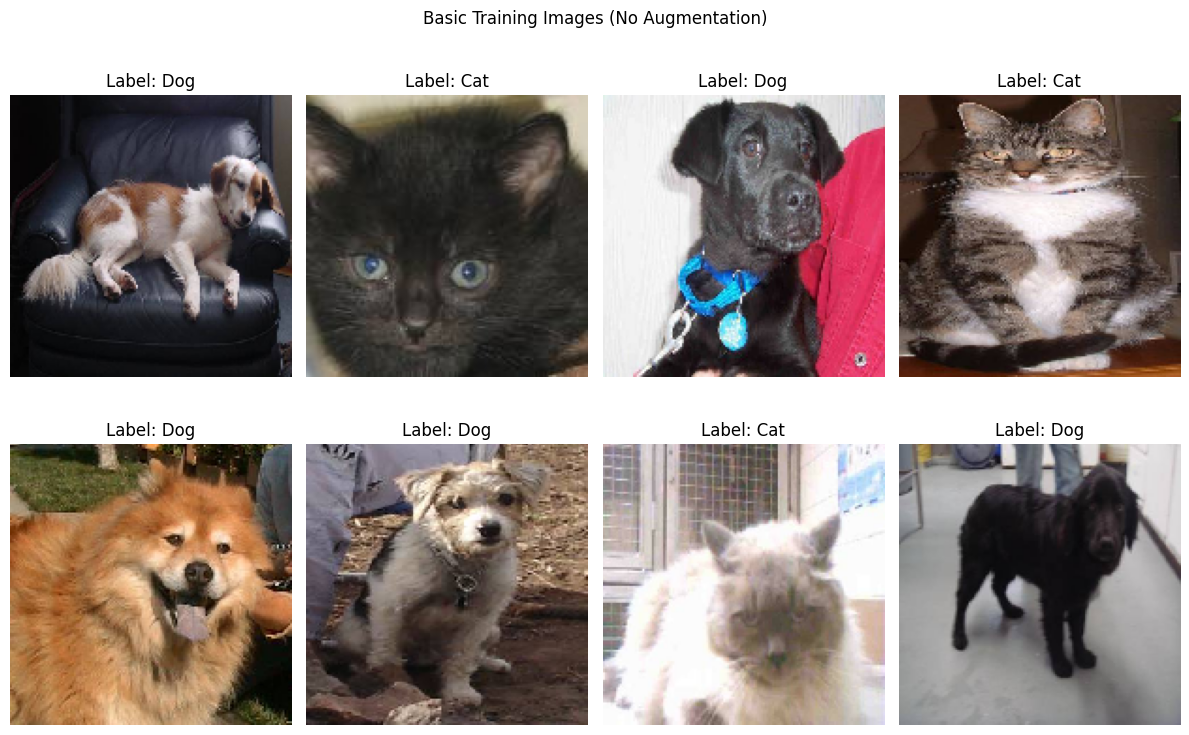

In [7]:


# Create basic data generators for vanilla CNN
train_gen_basic, val_gen_basic = create_basic_data_generators(train_dir, validation_dir)
visualize_sample_images(train_gen_basic, "Basic Training Images (No Augmentation)")



In [10]:
# ============================================================================
# STEP 2: BUILD AND TRAIN VANILLA CNN
# ============================================================================

def create_vanilla_cnn(img_height=150, img_width=150):
    """
    Create a VANILLA CNN model - just the basic building blocks!

    This is a pure CNN without any modern tricks:
    - NO dropout
    - NO batch normalization
    - NO advanced optimizations
    - Just Conv2D + MaxPooling + Dense layers

    Args:
        img_height: Input image height
        img_width: Input image width

    Returns:
        keras.Model: Compiled vanilla CNN model
    """
    print("\nSTEP 2: BUILDING VANILLA CNN")
    print("="*50)
    print("Creating basic CNN with NO modern tricks!")

    model = keras.Sequential(name="Vanilla_CNN")

    # TODO: STUDENT FILL IN
    # First Convolutional Block
    # Add Conv2D layer: 32 filters, (3,3) kernel, 'relu' activation
    # Specify input_shape=(img_height, img_width, 3) for RGB images
    model.add(layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(img_height, img_width, 3),
        name='conv2d_1'
    ))

    # TODO: STUDENT FILL IN
    # Add MaxPooling2D layer with (2,2) pool size
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1'))

    # TODO: STUDENT FILL IN
    # Second Convolutional Block
    # Add Conv2D layer: 64 filters, (3,3) kernel, 'relu' activation
    model.add(layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        name='conv2d_2'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2'))

    # TODO: STUDENT FILL IN
    # Third Convolutional Block
    # Add Conv2D layer: 128 filters, (3,3) kernel, 'relu' activation
    model.add(layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        activation='relu',
        name='conv2d_3'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_3'))

    # TODO: STUDENT FILL IN
    # Flatten the 3D feature maps to 1D for dense layers
    # This converts from spatial features to a vector
    model.add(layers.Flatten(name='flatten'))

    # TODO: STUDENT FILL IN
    # Add Dense layer with 512 units and 'relu' activation
    # This learns combinations of the extracted features
    model.add(layers.Dense(units=512, activation='relu', name='dense_1'))

    # TODO: STUDENT FILL IN
    # Output layer: 1 unit with 'sigmoid' activation for binary classification
    # Sigmoid outputs probability between 0 and 1
    model.add(layers.Dense(units=1, activation='sigmoid', name='output'))

    # TODO: STUDENT FILL IN
    # Compile model: optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
    # Adam: adaptive learning rate optimizer
    # Binary crossentropy: loss function for binary classification
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("\nVanilla CNN Architecture:")
    model.summary()
    print("Notice: NO dropout, NO batch normalization!")

    return model

def train_vanilla_cnn(model, train_generator, validation_generator, epochs=10):
    """Train vanilla CNN with basic training (no callbacks)."""
    print(f"\nTraining {model.name} (basic training, no callbacks)...")

    steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
    validation_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

    print(f"Epochs: {epochs}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Basic training - no callbacks
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        verbose=1
    )

    print("Vanilla CNN training completed!")
    return history

def evaluate_vanilla_cnn(model, validation_generator):
    """Evaluate vanilla CNN performance."""
    print(f"\nEvaluating {model.name}...")

    validation_generator.reset()
    test_loss, test_accuracy = model.evaluate(validation_generator, verbose=0)

    print(f"Vanilla CNN Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # Get predictions for later comparison
    validation_generator.reset()
    predictions = model.predict(validation_generator, verbose=0)
    true_labels = validation_generator.classes
    pred_labels = (predictions > 0.5).astype(int).flatten()

    return test_accuracy, pred_labels, true_labels, test_loss

def plot_vanilla_training(history):
    """Plot vanilla CNN training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title('Vanilla CNN - Training History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('Vanilla CNN - Loss History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


STEP 2: BUILDING VANILLA CNN
Creating basic CNN with NO modern tricks!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Vanilla CNN Architecture:


Model: "Vanilla_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Notice: NO dropout, NO batch normalization!

Training Vanilla_CNN (basic training, no callbacks)...
Epochs: 20
Steps per epoch: 63
Validation steps: 32
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.5145 - loss: 0.8045 - val_accuracy: 0.6540 - val_loss: 0.6710
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6318 - loss: 0.6500 - val_accuracy: 0.6570 - val_loss: 0.6416
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7226 - loss: 0.5464 - val_accuracy: 0.7180 - val_loss: 0.5833
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7718 - loss: 0.4847 - val_accuracy: 0.6790 - val_loss: 0.6168
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7786 - loss: 0.4555 - val_accuracy: 0.6970 - val_loss: 0.6522
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8267 - loss: 0.3756 - val_accuracy: 0.6810 - val_loss: 0.7324
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8621 - loss: 0.3053 - val_accuracy: 0.7190 - val_loss: 0.7157
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9190 - loss: 0.2215 - val_accuracy: 0.7090 - val_loss: 

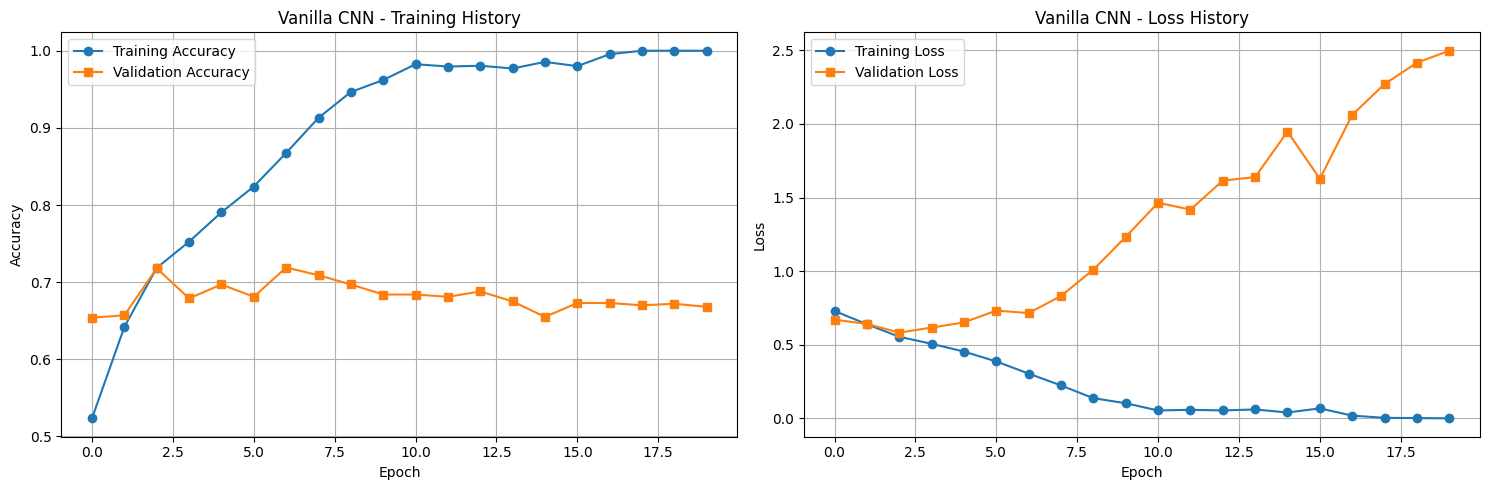

In [11]:
# STEP 2: Build and Train Vanilla CNN
vanilla_cnn = create_vanilla_cnn(150, 150)
history_vanilla = train_vanilla_cnn(vanilla_cnn, train_gen_basic, val_gen_basic, epochs=20)
acc_vanilla, pred_vanilla, true_vanilla, loss_vanilla = evaluate_vanilla_cnn(vanilla_cnn, val_gen_basic)
plot_vanilla_training(history_vanilla)

In [12]:
# ============================================================================
# STEP 3: BUILD AND TRAIN IMPROVED CNN
# ============================================================================

def create_augmented_data_generators(train_dir, validation_dir, img_height=150, img_width=150, batch_size=32):
    """Create data generators WITH augmentation for improved CNN."""
    print(f"\nSTEP 3: CREATING AUGMENTED DATA GENERATORS")
    print("="*50)
    print("Now with data augmentation for better generalization!")

    # Advanced training data generator with augmentation
    # Create ImageDataGenerator for training data with augmentation
    # Include: rescale=1./255 (normalize), rotation_range=20, width_shift_range=0.2,
    # height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
    train_datagen = ImageDataGenerator(
        rescale=1./255,           # Normalize pixel values to [0,1]
        rotation_range=20,    # Randomly rotate images up to 20 degrees
        width_shift_range=0.2,  # Randomly shift images horizontally by 20%
        height_shift_range=0.2, # Randomly shift images vertically by 20%
        shear_range=0.2,       # Randomly apply shear transformations
        zoom_range=0.2,        # Randomly zoom in/out by 20%
        horizontal_flip=True,   # Randomly flip images horizontally
        fill_mode='nearest'         # Fill in newly created pixels
    )

    # Validation data generator (only rescaling)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")
    print("Data augmentation includes: rotation, shifts, shear, zoom, flip")

    return train_generator, validation_generator

def create_improved_cnn(img_height=150, img_width=150):
    """
    Create an IMPROVED CNN model with modern techniques.

    Modern improvements:
    ✅ Batch normalization
    ✅ Dropout regularization
    ✅ More layers for better feature extraction

    Args:
        img_height: Input image height
        img_width: Input image width

    Returns:
        keras.Model: Compiled improved CNN model
    """
    print("\nBuilding IMPROVED CNN with modern techniques!")

    model = keras.Sequential(name="Improved_CNN")

    # First Block with Batch Normalization
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(img_height, img_width, 3), name='conv2d_1'))
    model.add(layers.BatchNormalization(name='bn_1'))  # ← NEW: Batch normalization
    model.add(layers.MaxPooling2D((2, 2), name='maxpool_1'))

    # Second Block with Batch Normalization
    model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
    model.add(layers.BatchNormalization(name='bn_2'))  # ← NEW: Batch normalization
    model.add(layers.MaxPooling2D((2, 2), name='maxpool_2'))

    # Third Block with Batch Normalization
    model.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_3'))
    model.add(layers.BatchNormalization(name='bn_3'))  # ← NEW: Batch normalization
    model.add(layers.MaxPooling2D((2, 2), name='maxpool_3'))

    # Fourth Block - More depth
    model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_4'))
    # model.add(layers.BatchNormalization(name='bn_4'))  # ← NEW: Batch normalization
    model.add(layers.MaxPooling2D((2, 2), name='maxpool_4'))

    # Dense layers with Dropout
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(512, activation='relu', name='dense_1'))
    model.add(layers.Dropout(0.2, name='dropout_1'))  # ← NEW: Dropout
    # model.add(layers.Dense(256, activation='relu', name='dense_2'))
    # model.add(layers.Dropout(0.2, name='dropout_2'))  # ← NEW: Dropout
    model.add(layers.Dense(1, activation='sigmoid', name='output'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("\nImproved CNN Architecture:")
    model.summary()
    print("Notice: WITH batch normalization, dropout, and more layers!")

    return model

def train_improved_cnn(model, train_generator, validation_generator, epochs=10):
    """Train improved CNN with advanced callbacks."""
    print(f"\nTraining {model.name} with advanced techniques...")

    # TODO: STUDENT FILL IN
    # Define advanced callbacks for better training
    # EarlyStopping: monitor='val_loss', patience=10, restore_best_weights=True
    # ReduceLROnPlateau: monitor='val_loss', factor=0.2, patience=5
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',        # 'val_loss'
            patience=10,         # 10
            restore_best_weights=True  # True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',        # 'val_loss'
            factor=0.2,           # 0.2
            patience=5          # 5
        )
    ]

    steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
    validation_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

    print(f"Max epochs: {epochs}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    print("Using callbacks: EarlyStopping + ReduceLROnPlateau")

    # Advanced training with callbacks
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    print("Improved CNN training completed!")
    return history

def evaluate_improved_cnn(model, validation_generator):
    """Evaluate improved CNN performance."""
    print(f"\nEvaluating {model.name}...")

    validation_generator.reset()
    test_loss, test_accuracy = model.evaluate(validation_generator, verbose=0)

    print(f"Improved CNN Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # Get predictions for comparison
    validation_generator.reset()
    predictions = model.predict(validation_generator, verbose=0)
    true_labels = validation_generator.classes
    pred_labels = (predictions > 0.5).astype(int).flatten()

    return test_accuracy, pred_labels, true_labels, test_loss

def plot_improved_training(history):
    """Plot improved CNN training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title('Improved CNN - Training History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('Improved CNN - Loss History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# STEP 3: Build and Train Improved CNN
train_gen_aug, val_gen_aug = create_augmented_data_generators(train_dir, validation_dir)
visualize_sample_images(train_gen_aug, "Augmented Training Images (With Data Aug)")

improved_cnn = create_improved_cnn(150, 150)
history_improved = train_improved_cnn(improved_cnn, train_gen_aug, val_gen_aug, epochs=20)
acc_improved, pred_improved, true_improved, loss_improved = evaluate_improved_cnn(improved_cnn, val_gen_aug)
plot_improved_training(history_improved)

In [ ]:
# ============================================================================
# STEP 4: COMPARE MODELS AND ANALYZE RESULTS
# ============================================================================

def compare_models(vanilla_acc, vanilla_loss, improved_acc, improved_loss):
    """Compare the performance of both models."""
    print("\nSTEP 4: MODEL COMPARISON AND ANALYSIS")
    print("="*50)

    print("🔍 PERFORMANCE COMPARISON:")
    print(f"Vanilla CNN:   {vanilla_acc:.4f} ({vanilla_acc*100:.2f}%) - Loss: {vanilla_loss:.4f}")
    print(f"Improved CNN:  {improved_acc:.4f} ({improved_acc*100:.2f}%) - Loss: {improved_loss:.4f}")

    if improved_acc > vanilla_acc:
        improvement = ((improved_acc - vanilla_acc) / vanilla_acc) * 100
        print(f"📈 Accuracy Improvement: {improvement:.2f}% better!")

    if improved_loss < vanilla_loss:
        loss_improvement = ((vanilla_loss - improved_loss) / vanilla_loss) * 100
        print(f"📉 Loss Improvement: {loss_improvement:.2f}% better!")

def plot_model_comparison(history_vanilla, history_improved):
    """Plot side-by-side comparison of both models."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Training accuracy
    ax1.plot(history_vanilla.history['accuracy'], label='Vanilla CNN', marker='o', color='red')
    ax1.plot(history_improved.history['accuracy'], label='Improved CNN', marker='s', color='blue')
    ax1.set_title('Training Accuracy Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Validation accuracy
    ax2.plot(history_vanilla.history['val_accuracy'], label='Vanilla CNN', marker='o', color='red')
    ax2.plot(history_improved.history['val_accuracy'], label='Improved CNN', marker='s', color='blue')
    ax2.set_title('Validation Accuracy Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Training loss
    ax3.plot(history_vanilla.history['loss'], label='Vanilla CNN', marker='o', color='red')
    ax3.plot(history_improved.history['loss'], label='Improved CNN', marker='s', color='blue')
    ax3.set_title('Training Loss Comparison')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True)

    # Validation loss
    ax4.plot(history_vanilla.history['val_loss'], label='Vanilla CNN', marker='o', color='red')
    ax4.plot(history_improved.history['val_loss'], label='Improved CNN', marker='s', color='blue')
    ax4.set_title('Validation Loss Comparison')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True)

    plt.suptitle('Vanilla CNN vs Improved CNN - Complete Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(y_true_vanilla, y_pred_vanilla, y_true_improved, y_pred_improved):
    """Plot confusion matrices for both models."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Vanilla CNN Confusion Matrix
    cm_vanilla = confusion_matrix(y_true_vanilla, y_pred_vanilla)
    sns.heatmap(cm_vanilla, annot=True, fmt='d', cmap='Reds', ax=ax1,
                xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    ax1.set_title('Vanilla CNN\nConfusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # Improved CNN Confusion Matrix
    cm_improved = confusion_matrix(y_true_improved, y_pred_improved)
    sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    ax2.set_title('Improved CNN\nConfusion Matrix')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

def analyze_key_differences(vanilla_model, improved_model):
    """Analyze the key architectural and training differences."""
    print("\n🛠️ KEY DIFFERENCES ANALYSIS:")
    print("-" * 40)

    print("VANILLA CNN:")
    print("  ❌ Basic Conv2D + MaxPool + Dense")
    print("  ❌ No regularization techniques")
    print("  ❌ No data augmentation")
    print("  ❌ Basic training (no callbacks)")
    print("  ❌ Likely to overfit quickly")

    print("\nIMPROVED CNN:")
    print("  ✅ Batch normalization after each conv layer")
    print("  ✅ Dropout regularization in dense layers")
    print("  ✅ Data augmentation (rotation, shifts, flips)")
    print("  ✅ Advanced training callbacks")
    print("  ✅ Better generalization")

    print(f"\n📊 MODEL COMPLEXITY:")
    print(f"Vanilla CNN Parameters:   {vanilla_model.count_params():,}")
    print(f"Improved CNN Parameters:  {improved_model.count_params():,}")

def save_models(vanilla_model, improved_model):
    """Save both models to disk."""
    vanilla_model.save("vanilla_cnn_model.h5")
    improved_model.save("improved_cnn_model.h5")
    print("\n💾 Models saved:")
    print("  - vanilla_cnn_model.h5")
    print("  - improved_cnn_model.h5")



In [ ]:




# STEP 4: Compare and Analyze
compare_models(acc_vanilla, loss_vanilla, acc_improved, loss_improved)
plot_model_comparison(history_vanilla, history_improved)
plot_confusion_matrices(true_vanilla, pred_vanilla, true_improved, pred_improved)
analyze_key_differences(vanilla_cnn, improved_cnn)
save_models(vanilla_cnn, improved_cnn)

print("\n🎉 EXERCISE COMPLETED!")
print("You've successfully compared vanilla CNN vs improved CNN approaches.")



🎓 LEARNING SUMMARY:

WHAT YOU'VE LEARNED:
1. Basic CNN architecture (vanilla approach)
2. Impact of modern techniques:
   - Batch normalization → Training stability
   - Dropout → Overfitting prevention  
   - Data augmentation → Better generalization
   - Advanced callbacks → Training optimization

EXPECTED RESULTS:
- Vanilla CNN: ~65-75% accuracy (may overfit)
- Improved CNN: ~75-85% accuracy (better generalization)




## DISCUSSION QUESTIONS FOR STUDENTS

1. Why are CNNs better suited for image classification compared to regular dense networks?
   Hint: Think about spatial relationships and parameter sharing

2. What is the purpose of each layer type:
   - Convolutional layers: Feature extraction with learnable filters
   - Pooling layers: Dimensionality reduction and translation invariance
   - Dropout layers: Regularization to prevent overfitting
   - Batch normalization: Stabilize training and improve convergence

3. How does data augmentation help improve model performance?
   Hint: Think about dataset size and model generalization

4. What happens to the spatial dimensions as data flows through the CNN?
   Hint: Track the output shape after each layer

5. Why do we use different numbers of filters in different layers?
   Hint: Think about feature hierarchy (simple → complex)

6. How do early stopping and learning rate reduction help during training?
   Hint: Think about overfitting and optimization

7. Experiment: Try different architectures. What happens if you:
   - Remove pooling layers?
   - Use different filter sizes (5x5 instead of 3x3)?
   - Add more/fewer layers?
   - Change the number of filters?

8. What are the trade-offs between model complexity and performance?
   Hint: Consider training time, memory usage, and accuracy

TROUBLESHOOTING:
- If download fails, the code will create synthetic demo images
- All files are saved to current directory (no permission issues)
- Required packages: pip install tensorflow pillow scikit-learn matplotlib seaborn

EXPECTED RESULTS:
- Simple CNN: ~65-75% accuracy
- Improved CNN: ~75-85% accuracy  
- Training should complete in 5-15 minutes depending on hardware
